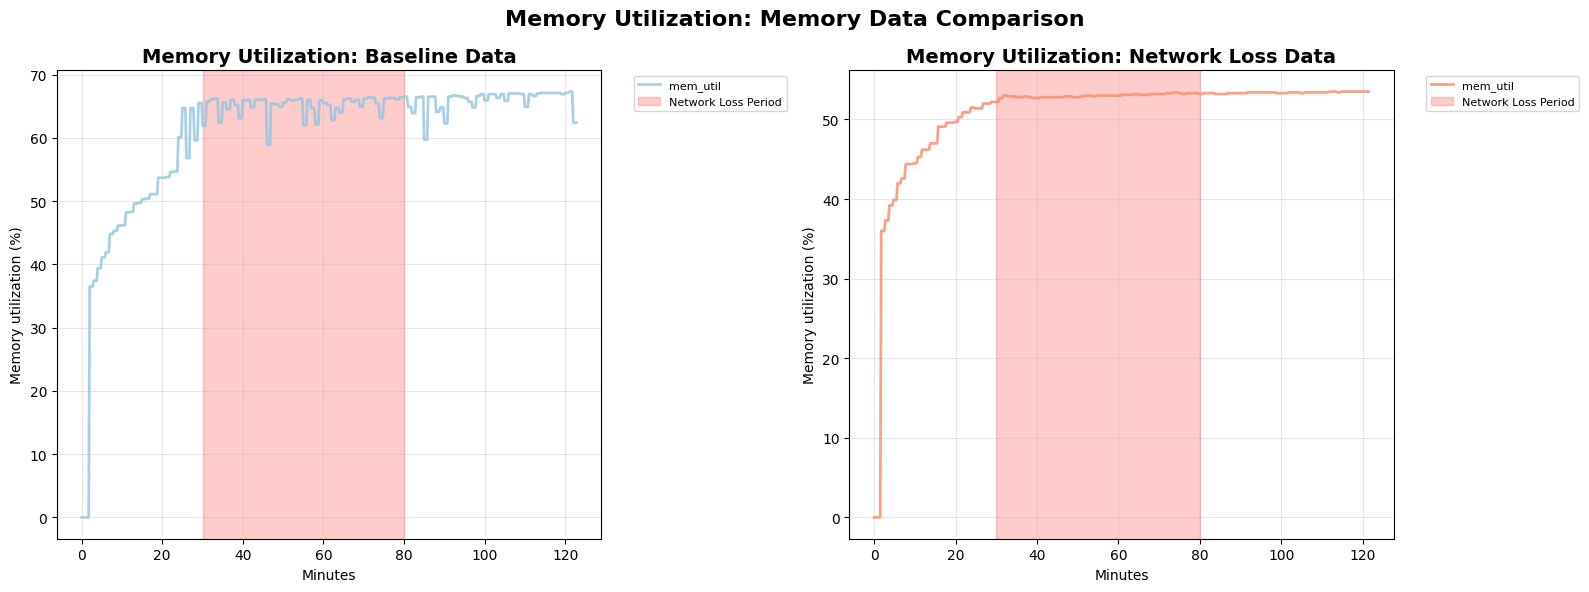

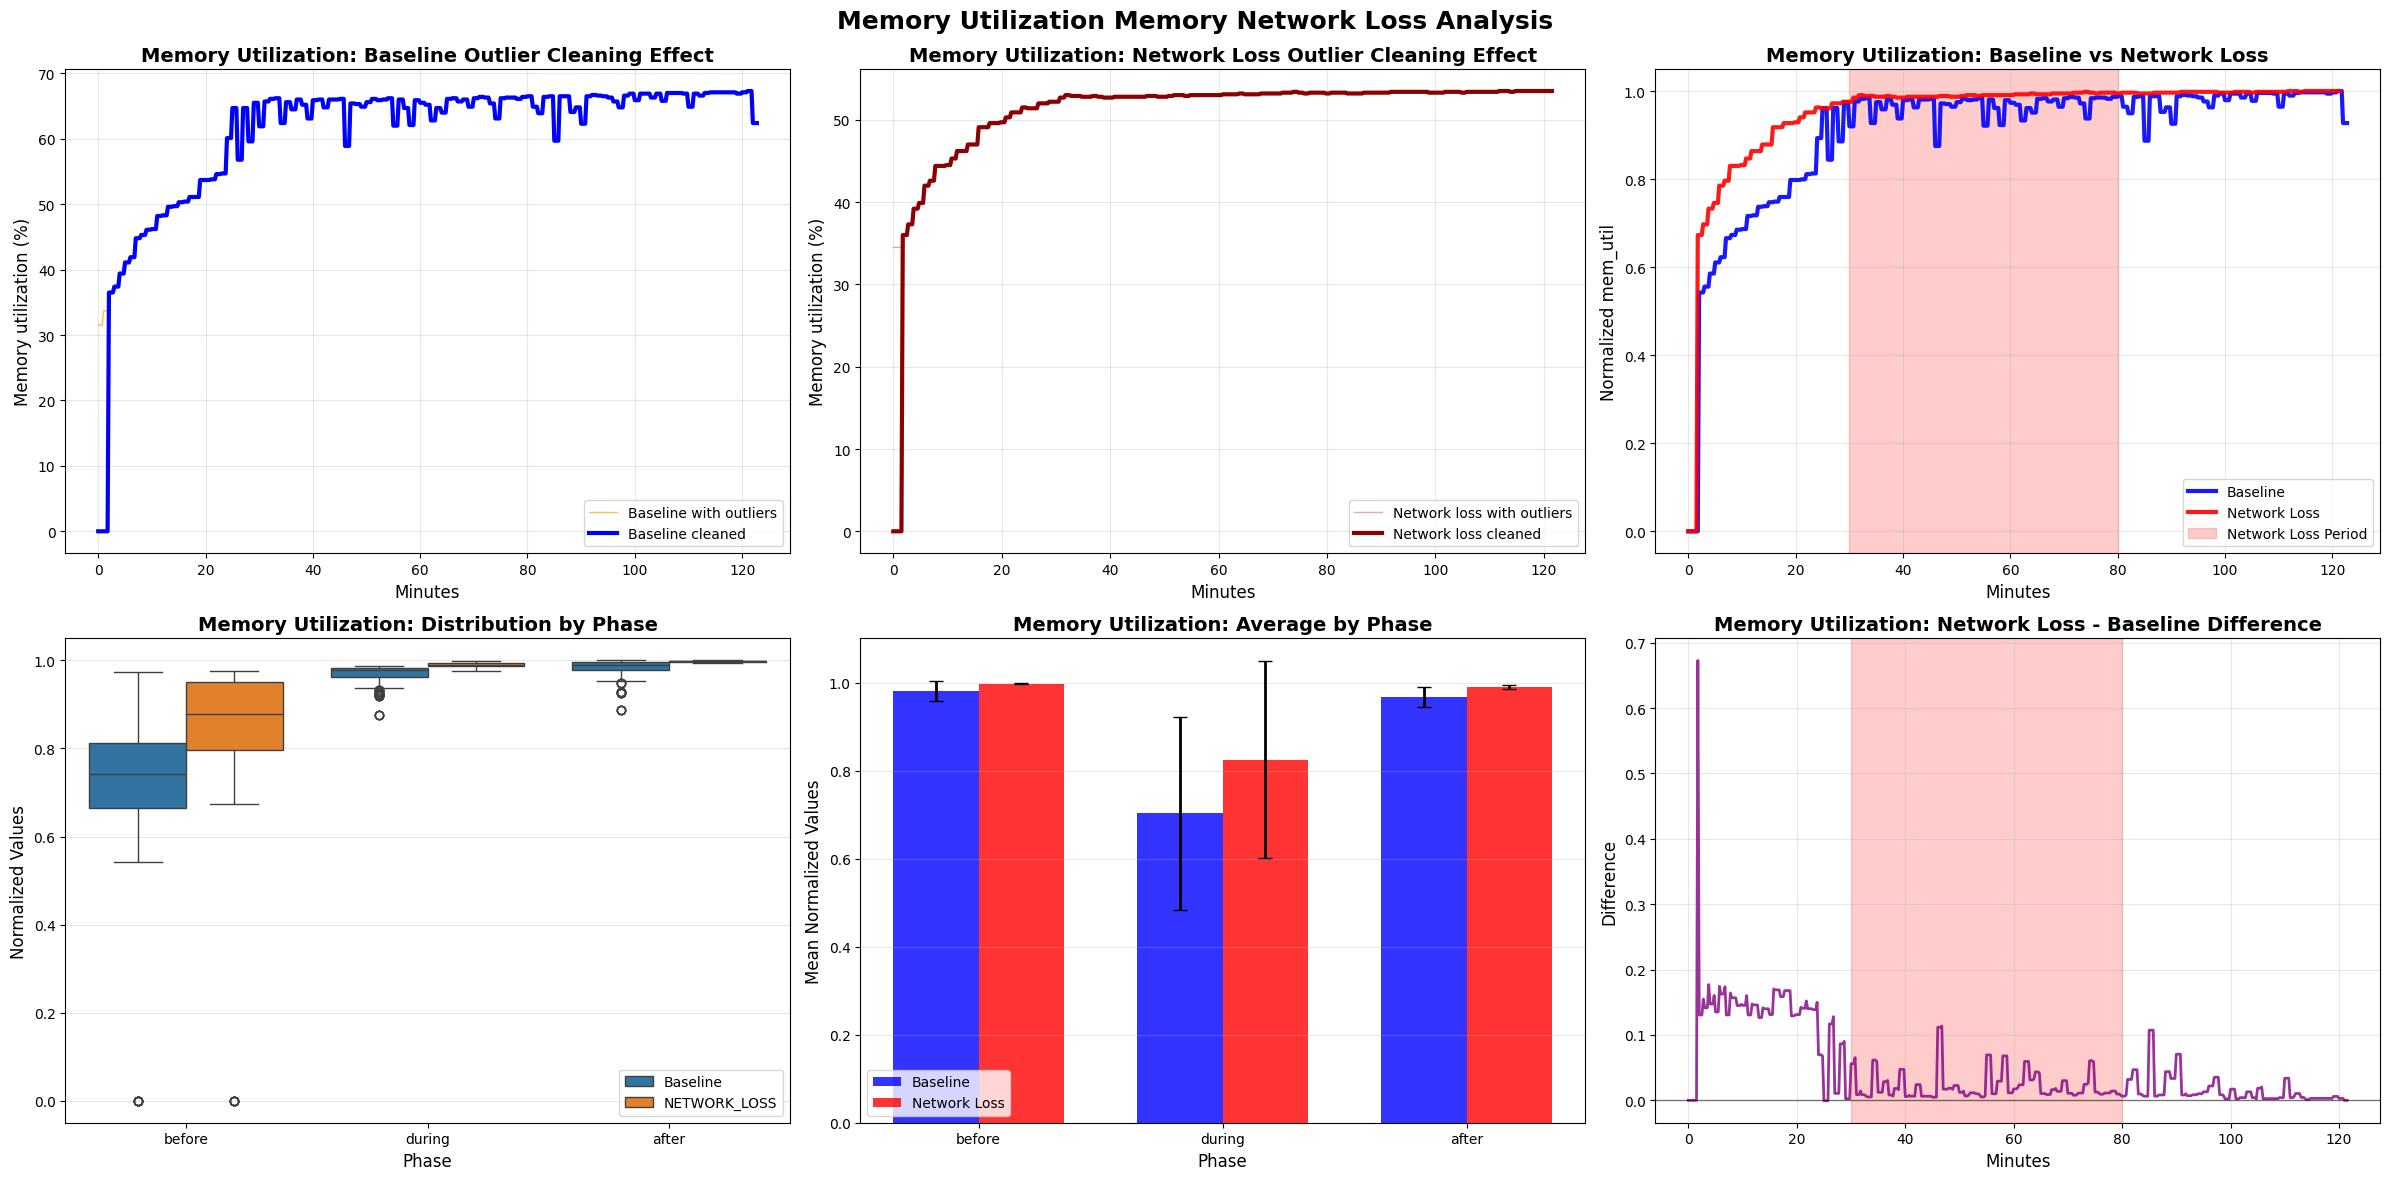


MEMORY UTILIZATION - NETWORK LOSS ANALYSIS RESULTS

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9813  0.0230  0.8871  1.0000
before  0.7030  0.2191  0.0000  0.9733
during  0.9678  0.0229  0.8752  0.9881

NETWORK LOSS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9977  0.0017  0.9944  1.0000
before  0.8254  0.2229  0.0000  0.9757
during  0.9905  0.0040  0.9757  0.9981

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -4.29, p=  0.0000 SIGNIFICANT
  DURING  : t=-13.90, p=  0.0000 SIGNIFICANT
  AFTER   : t= -9.16, p=  0.0000 SIGNIFICANT

NETWORK LOSS IMPACT ON MEMORY:
  BEFORE  :  +17.41% INCREASE
  DURING  :   +2.35% INCREASE
  AFTER   :   +1.67% INCREASE


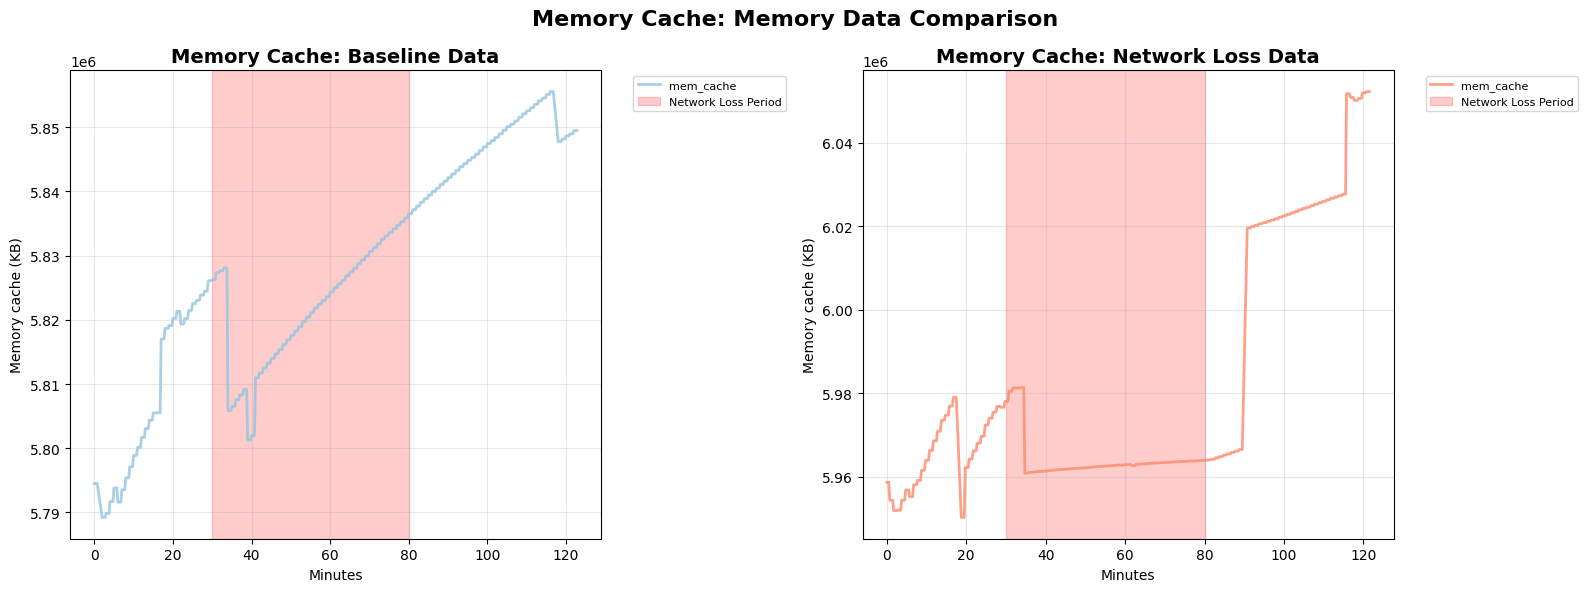

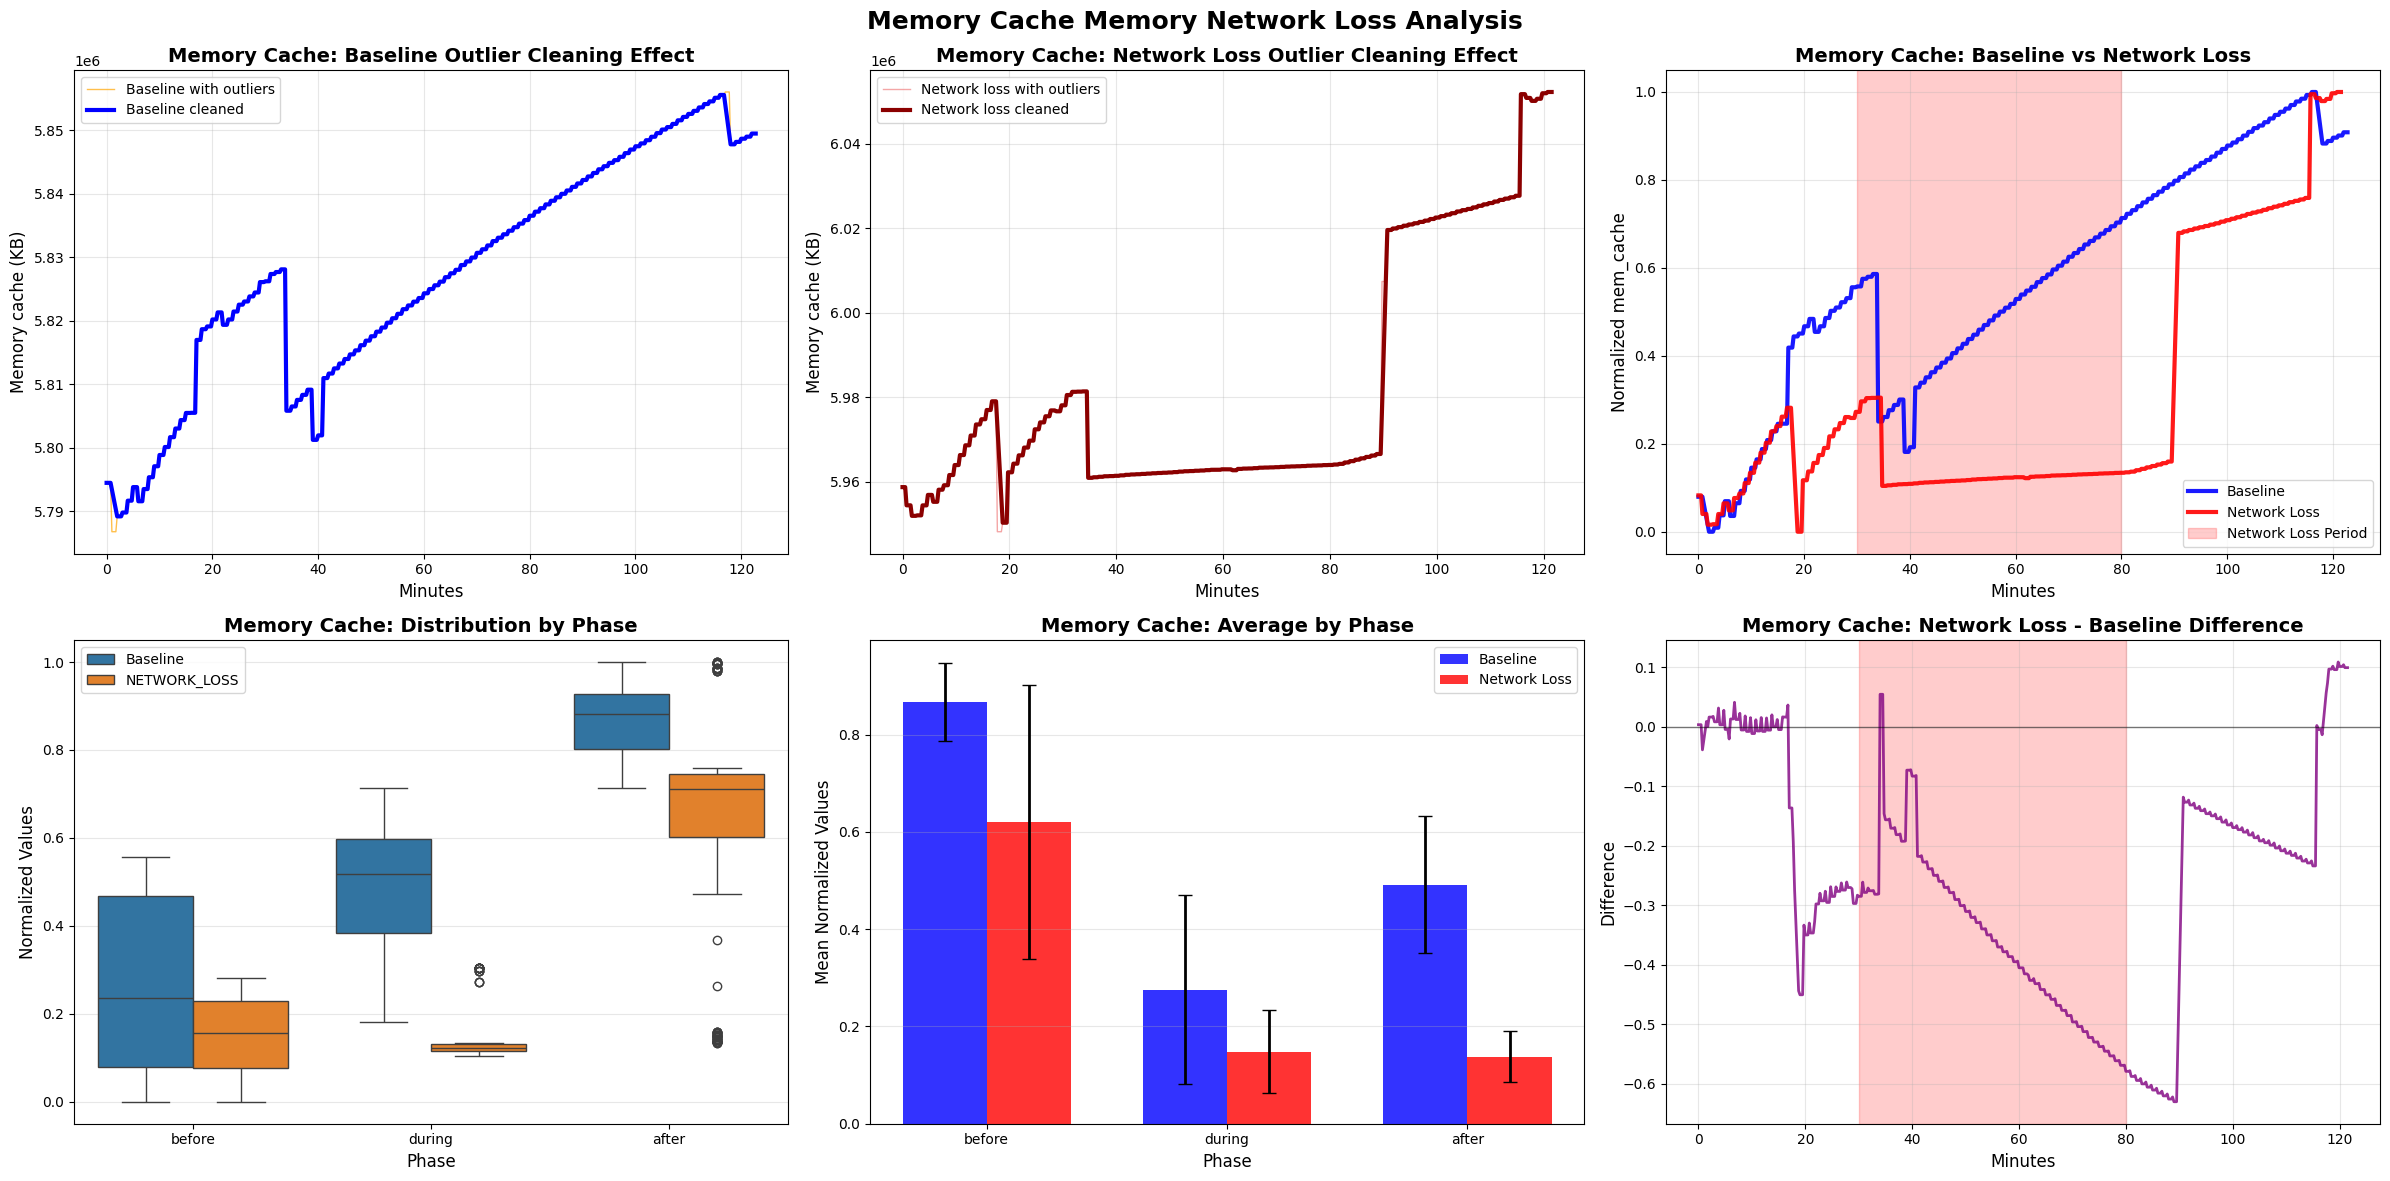


MEMORY CACHE - NETWORK LOSS ANALYSIS RESULTS

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.8673  0.0798  0.7134  1.0000
before  0.2756  0.1949  0.0000  0.5559
during  0.4914  0.1404  0.1815  0.7134

NETWORK LOSS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.6198  0.2817  0.1341  1.0000
before  0.1483  0.0856  0.0000  0.2819
during  0.1376  0.0526  0.1042  0.3049

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  6.55, p=  0.0000 SIGNIFICANT
  DURING  : t= 33.46, p=  0.0000 SIGNIFICANT
  AFTER   : t= 11.05, p=  0.0000 SIGNIFICANT

NETWORK LOSS IMPACT ON MEMORY:
  BEFORE  :  -46.18% DECREASE
  DURING  :  -72.00% DECREASE
  AFTER   :  -28.54% DECREASE


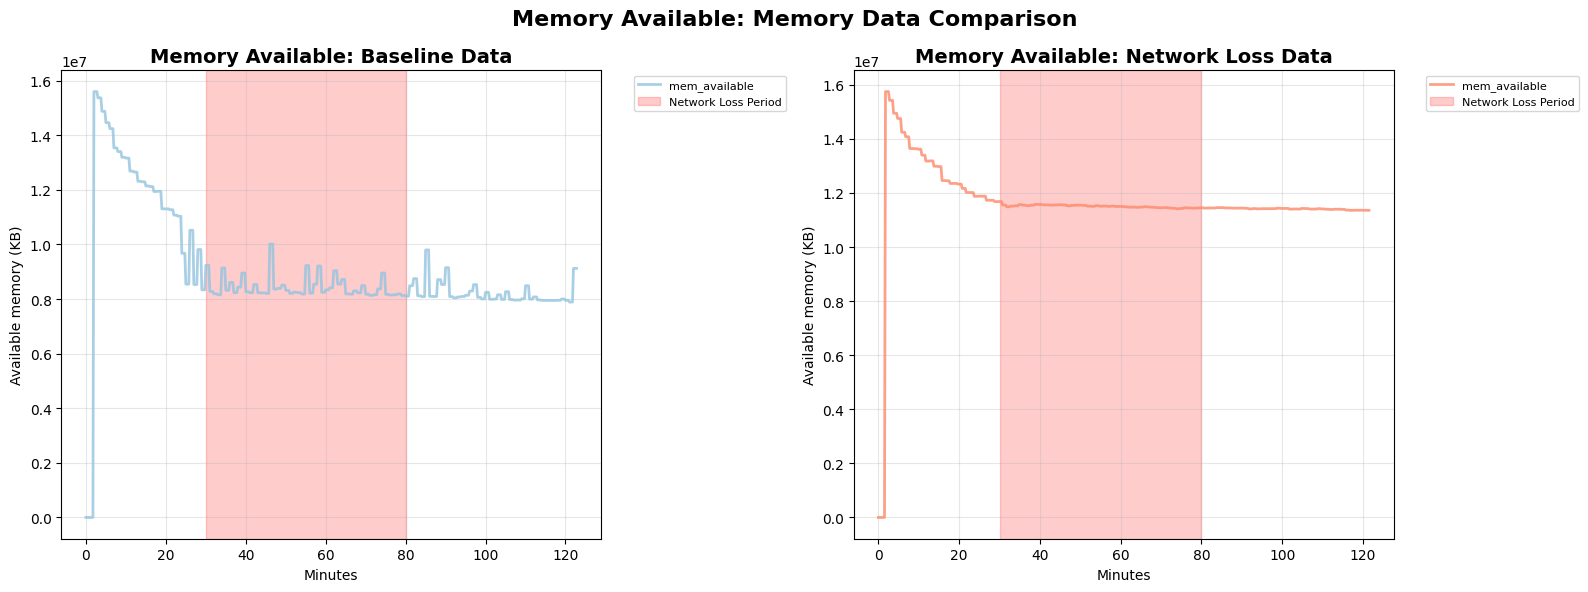

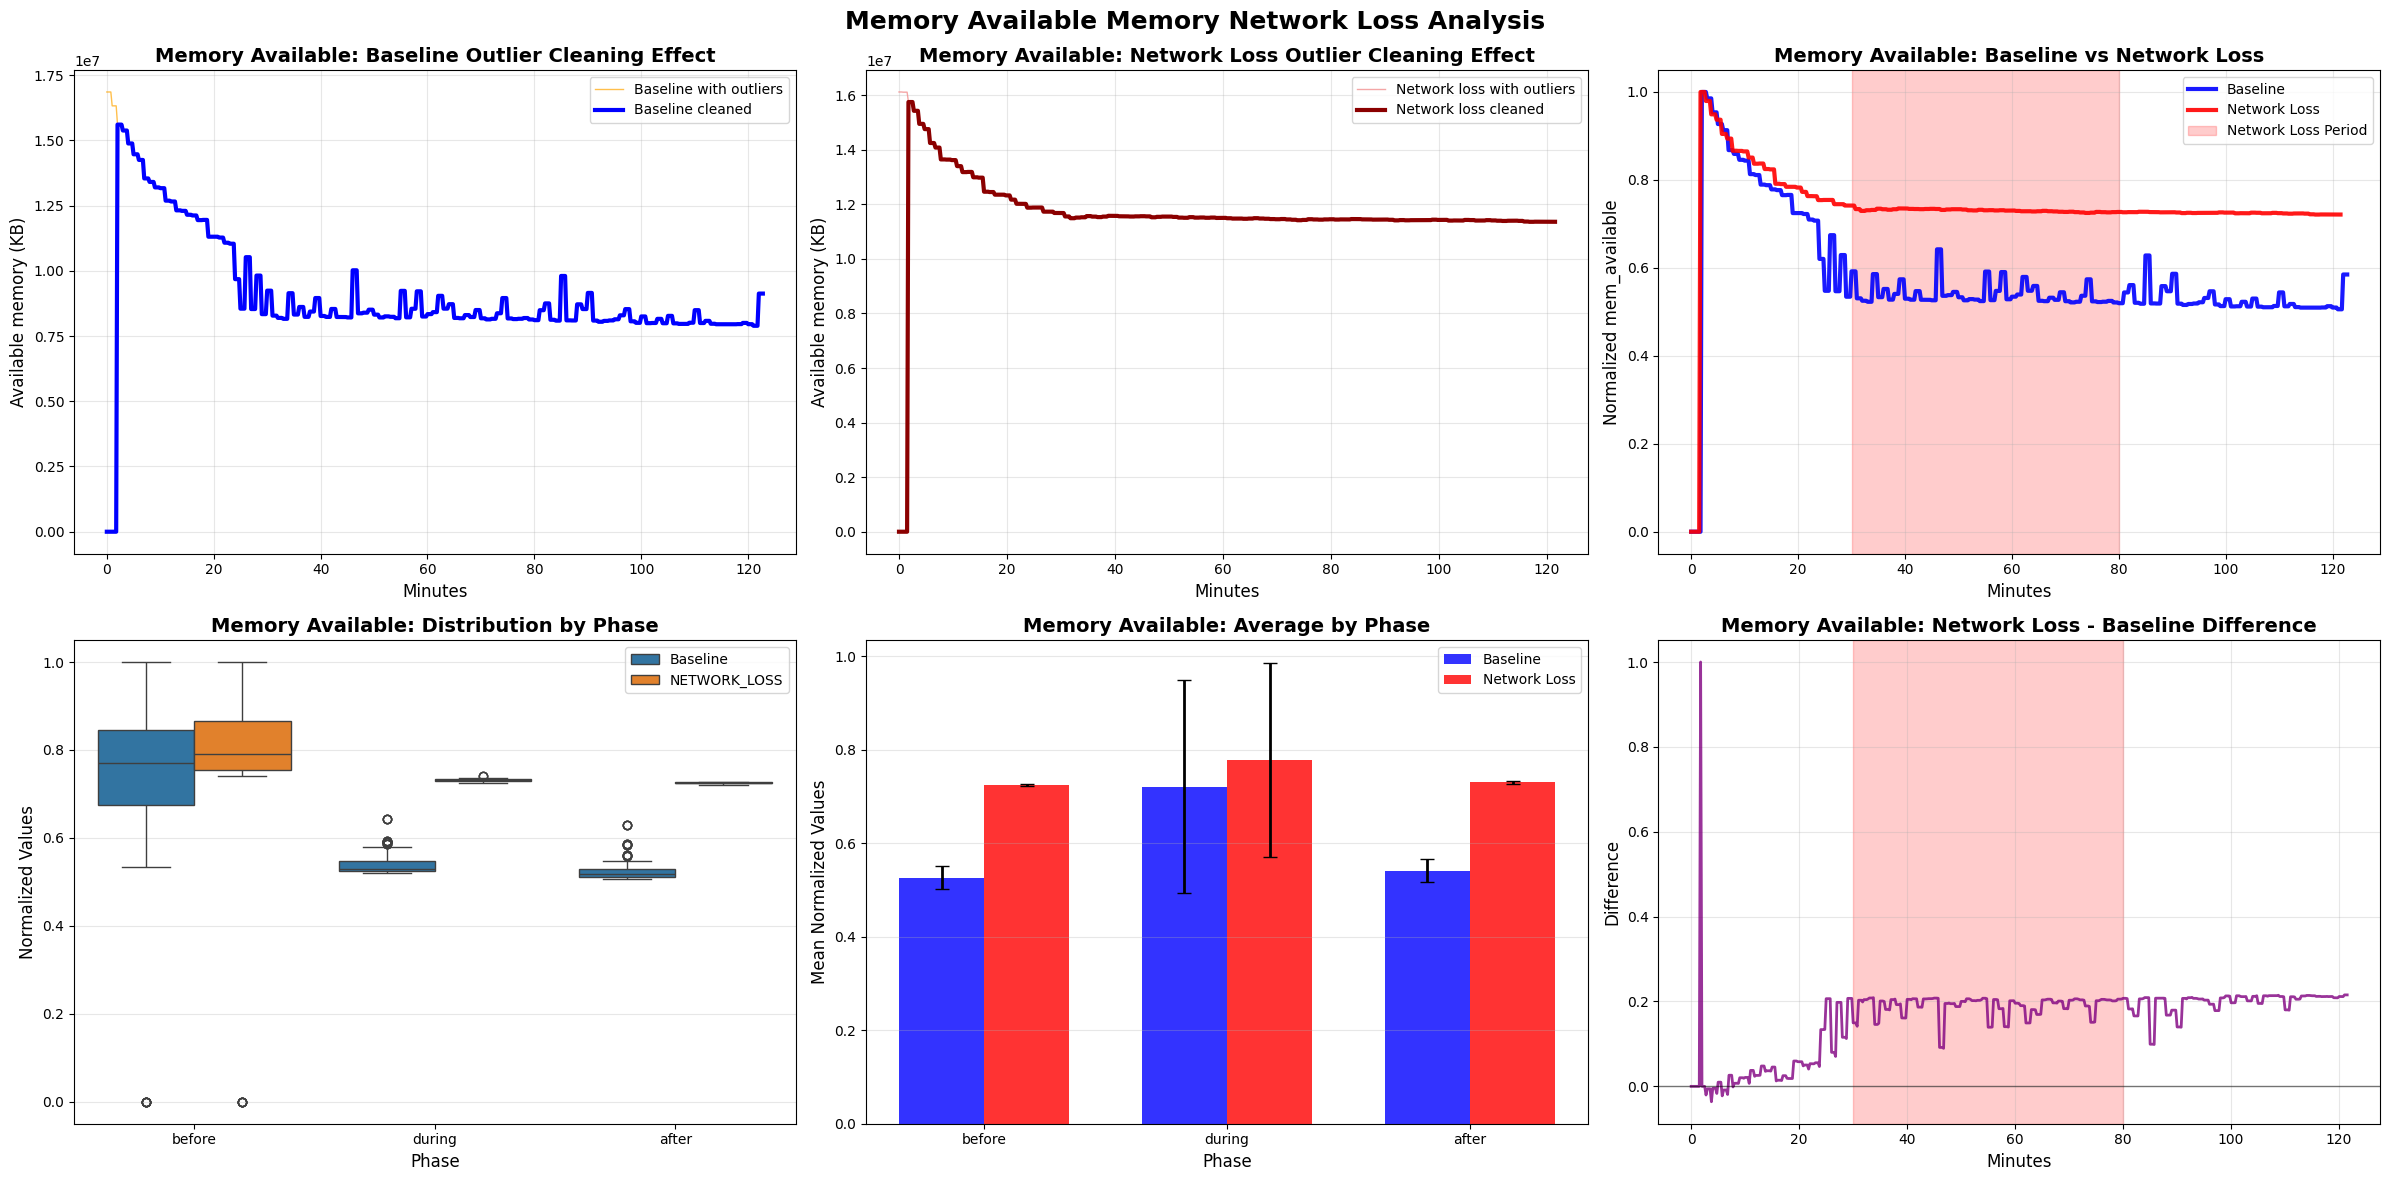


MEMORY AVAILABLE - NETWORK LOSS ANALYSIS RESULTS

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.5265  0.0249  0.5058  0.6282
before  0.7209  0.2279  0.0000  1.0000
during  0.5412  0.0248  0.5197  0.6422

NETWORK LOSS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.7248  0.0017  0.7212  0.7276
before  0.7783  0.2074  0.0000  1.0000
during  0.7307  0.0031  0.7249  0.7417

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.04, p=  0.0425 SIGNIFICANT
  DURING  : t=-107.46, p=  0.0000 SIGNIFICANT
  AFTER   : t=-102.57, p=  0.0000 SIGNIFICANT

NETWORK LOSS IMPACT ON MEMORY:
  BEFORE  :   +7.96% INCREASE
  DURING  :  +35.01% INCREASE
  AFTER   :  +37.67% INCREASE


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load all memory datasets
df_mem_util = pd.read_csv("mem_util.csv")
df_mem_cache = pd.read_csv("mem_cache.csv")
df_mem_available = pd.read_csv("mem_available.csv")

df_baseline_mem_util = pd.read_csv("../../baseline/memory related/mem_util.csv")
df_baseline_mem_cache = pd.read_csv("../../baseline/memory related/mem_cache.csv")
df_baseline_mem_available = pd.read_csv("../../baseline/memory related/mem_available.csv")

# Add source labels
df_mem_util["source"] = "NETWORK_LOSS"
df_mem_cache["source"] = "NETWORK_LOSS"
df_mem_available["source"] = "NETWORK_LOSS"

df_baseline_mem_util["source"] = "BASELINE"
df_baseline_mem_cache["source"] = "BASELINE"
df_baseline_mem_available["source"] = "BASELINE"

# Convert to datetime
df_mem_util["Time"] = pd.to_datetime(df_mem_util["Time"])
df_mem_cache["Time"] = pd.to_datetime(df_mem_cache["Time"])
df_mem_available["Time"] = pd.to_datetime(df_mem_available["Time"])

df_baseline_mem_util["Time"] = pd.to_datetime(df_baseline_mem_util["Time"])
df_baseline_mem_cache["Time"] = pd.to_datetime(df_baseline_mem_cache["Time"])
df_baseline_mem_available["Time"] = pd.to_datetime(df_baseline_mem_available["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_mem_util["Time"].min() - df_mem_util["Time"].min()
df_mem_util["Time"] += time_offset
df_mem_cache["Time"] += time_offset
df_mem_available["Time"] += time_offset

# Convert timeline to minutes
all_dfs = [
    df_mem_util, df_mem_cache, df_mem_available,
    df_baseline_mem_util, df_baseline_mem_cache, df_baseline_mem_available
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# Store original datasets before cleaning
original_datasets = {
    'Memory Utilization': {'networkloss': df_mem_util.copy(), 'baseline': df_baseline_mem_util.copy()},
    'Memory Cache': {'networkloss': df_mem_cache.copy(), 'baseline': df_baseline_mem_cache.copy()},
    'Memory Available': {'networkloss': df_mem_available.copy(), 'baseline': df_baseline_mem_available.copy()}
}

# Get appropriate y-axis label based on dataset type
def get_y_label(dataset_name):
    if 'utilization' in dataset_name.lower():
        return 'Memory utilization (%)'
    elif 'cache' in dataset_name.lower():
        return 'Memory cache (KB)'
    elif 'available' in dataset_name.lower():
        return 'Available memory (KB)'
    else:
        return 'Value'

# Isolation Forest outlier detection for memory metrics
def remove_outliers_isolation_forest_memory(df, contamination=0.02):
    df_clean = df.copy()
    outlier_stats = {}
    
    # Get all numeric columns except Time, Minutes, and source
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if len(numeric_cols) == 0:
        outlier_stats['_summary'] = {
            'total_outliers': 0,
            'contamination_rate': contamination,
            'features_used': 0,
            'percentage_removed': 0
        }
        return df_clean, outlier_stats
    
    feature_matrix = df[numeric_cols].fillna(0).values
    
    # Check if there's enough variance to detect outliers
    if np.std(feature_matrix.flatten()) > 1e-10:
        # Scale features for better performance
        scaler = StandardScaler()
        feature_matrix_scaled = scaler.fit_transform(feature_matrix)
        
        # Initialize and fit Isolation Forest
        iso_forest = IsolationForest(
            contamination=contamination,
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        
        # Fit and predict
        iso_forest.fit(feature_matrix_scaled)
        outlier_predictions = iso_forest.predict(feature_matrix_scaled)
        
        # Create outlier mask
        outlier_mask = outlier_predictions == -1
        
        # Apply outlier removal to each numeric column
        for col in numeric_cols:
            outlier_stats[col] = {
                'count': outlier_mask.sum(),
                'percentage': (outlier_mask.sum() / len(df[col])) * 100,
                'method': 'isolation_forest'
            }
            
            # Set outliers to NaN and interpolate
            df_clean.loc[outlier_mask, col] = np.nan
            df_clean[col] = df_clean[col].interpolate(method='linear').fillna(0)
        
        outlier_stats['_summary'] = {
            'total_outliers': outlier_mask.sum(),
            'contamination_rate': contamination,
            'features_used': len(numeric_cols),
            'percentage_removed': (outlier_mask.sum() / len(df)) * 100
        }
    else:
        for col in numeric_cols:
            outlier_stats[col] = {
                'count': 0,
                'percentage': 0,
                'method': 'isolation_forest'
            }
        
        outlier_stats['_summary'] = {
            'total_outliers': 0,
            'contamination_rate': contamination,
            'features_used': len(numeric_cols),
            'percentage_removed': 0
        }
    
    return df_clean, outlier_stats

# Outlier cleaning with tracking
datasets_clean = {}
all_outlier_stats = {}

for dataset_name, dataset_pair in original_datasets.items():
    datasets_clean[dataset_name] = {}
    all_outlier_stats[dataset_name] = {}
    
    for source_type, df in dataset_pair.items():
        df_clean, stats = remove_outliers_isolation_forest_memory(df, contamination=0.02)
        datasets_clean[dataset_name][source_type] = df_clean
        all_outlier_stats[dataset_name][source_type] = stats

# Normalization function
def normalize_df_memory(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result

# Add phase column 
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df

# Plot original memory data
def plot_original_memory_data(dataset_name, networkloss_df, baseline_df, delay_minutes, duration_minutes):
    # Get all numeric columns except Time, Minutes
    numeric_cols = [col for col in networkloss_df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if len(numeric_cols) == 0:
        return
    
    # Show all columns
    display_cols = numeric_cols
    
    # Get appropriate y-axis label
    y_label = get_y_label(dataset_name)
    
    # Create 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Baseline Data
    colors_baseline = plt.cm.Blues(np.linspace(0.4, 0.9, len(display_cols)))
    for i, col in enumerate(display_cols):
        ax1.plot(baseline_df['Minutes'], baseline_df[col], 
                color=colors_baseline[i], linewidth=2, alpha=0.8, 
                label=col)
    
    ax1.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Network Loss Period")
    ax1.set_title(f'{dataset_name}: Baseline Data', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Minutes')
    ax1.set_ylabel(y_label)
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Plot 2: Network Loss Data
    colors_stress = plt.cm.Reds(np.linspace(0.4, 0.9, len(display_cols)))
    for i, col in enumerate(display_cols):
        ax2.plot(networkloss_df['Minutes'], networkloss_df[col], 
                color=colors_stress[i], linewidth=2, alpha=0.8, 
                label=col)
    
    ax2.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Network Loss Period")
    ax2.set_title(f'{dataset_name}: Network Loss Data', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Minutes')
    ax2.set_ylabel(y_label)
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    plt.suptitle(f'{dataset_name}: Memory Data Comparison', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Enhanced analysis and plot function for memory metrics
def analyze_and_plot_memory_dataset_wide(dataset_name, networkloss_df_clean, baseline_df_clean, delay_minutes, duration_minutes):
    
    plot_original_memory_data(dataset_name, networkloss_df_clean, baseline_df_clean, delay_minutes, duration_minutes)
    
    # Get original datasets for comparison
    networkloss_df_original = original_datasets[dataset_name]['networkloss']
    baseline_df_original = original_datasets[dataset_name]['baseline']
    
    # Get numeric columns for memory metrics
    numeric_cols = [col for col in networkloss_df_clean.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    networkloss_norm = normalize_df_memory(networkloss_df_clean, numeric_cols)
    baseline_norm = normalize_df_memory(baseline_df_clean, numeric_cols)
    
    # For memory metrics, we typically have single metrics
    main_metric = numeric_cols[0] if numeric_cols else None
    
    if main_metric is None:
        return None
    
    # Add phase information
    networkloss_norm = add_phase_column(networkloss_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    # Statistical analysis
    stats_baseline = baseline_norm.groupby('phase')[main_metric].agg(['mean', 'std', 'min', 'max'])
    stats_networkloss = networkloss_norm.groupby('phase')[main_metric].agg(['mean', 'std', 'min', 'max'])
    
    # Combined dataframe for analysis
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm[main_metric],
        'NETWORK_LOSS': networkloss_norm[main_metric],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': networkloss_norm[main_metric] - baseline_norm[main_metric]
    })
    
    # T-tests for statistical significance
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['NETWORK_LOSS'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    # Calculate percentage impact
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        networkloss_mean = stats_networkloss.loc[phase, 'mean']
        impact[phase] = ((networkloss_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # Get appropriate y-axis label
    y_label = get_y_label(dataset_name)
    
    # Comprehensive analysis plotting
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline outlier cleaning effect
    plt.subplot(2, 3, 1)
    plt.plot(baseline_df_original['Minutes'], baseline_df_original[main_metric], 
             label='Baseline with outliers', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df_clean['Minutes'], baseline_df_clean[main_metric], 
             label='Baseline cleaned', linewidth=3, color='blue')
    plt.title(f'{dataset_name}: Baseline Outlier Cleaning Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. Network loss outlier cleaning effect
    plt.subplot(2, 3, 2)
    plt.plot(networkloss_df_original['Minutes'], networkloss_df_original[main_metric], 
             label='Network loss with outliers', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(networkloss_df_clean['Minutes'], networkloss_df_clean[main_metric], 
             label='Network loss cleaned', linewidth=3, color='darkred')
    plt.title(f'{dataset_name}: Network Loss Outlier Cleaning Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison
    plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm[main_metric], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(networkloss_norm['Minutes'], networkloss_norm[main_metric], 
             label='Network Loss', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Network Loss Period")
    plt.title(f"{dataset_name}: Baseline vs Network Loss", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel(f"Normalized {main_metric}", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # 4. Box plot by phase
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'NETWORK_LOSS', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{dataset_name}: Distribution by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    
    # 5. Statistics by phase
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_networkloss['mean'], width, label='Network Loss', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_networkloss['mean'], yerr=stats_networkloss['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title(f'{dataset_name}: Average by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Mean Normalized Values', fontsize=12)
    plt.xticks(x, phases)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{dataset_name}: Network Loss - Baseline Difference', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} Memory Network Loss Analysis', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    # Print statistical results
    print(f"\n{dataset_name.upper()} - NETWORK LOSS ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    print(f"\nBASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\nNETWORK LOSS STATISTICS BY PHASE:")
    print(stats_networkloss.round(4))
    
    print(f"\nSTATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "SIGNIFICANT" if test['p'] < 0.05 else "NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} {sig}")
    
    print(f"\nNETWORK LOSS IMPACT ON MEMORY:")
    for phase, change in impact.items():
        direction = "INCREASE" if change > 0 else "DECREASE" if change < 0 else "NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% {direction}")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_networkloss': stats_networkloss,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'main_metric': main_metric,
        'numeric_columns': numeric_cols
    }

# Run analysis 
analysis_results = {}

for dataset_name in datasets_clean.keys():
    networkloss_clean = datasets_clean[dataset_name]['networkloss']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    analysis_results[dataset_name] = analyze_and_plot_memory_dataset_wide(
        dataset_name, 
        networkloss_clean, 
        baseline_clean, 
        delay, 
        duration
    )
